# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [5]:
names = {'student_1': "Fredrik Bixo",
        'student_2': "Pierre Armel Mbanga Ndjock"}

sciper = {'student_1': 300685, 
          'student_2': 229047}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os, sys
import copy

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="/mnt/storage01/mbanga/ann/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 



# Plotting

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['acc'], label = "training")
    ax2.plot(history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [6]:
conversations = getRawDataFromFile()

In [7]:
len(conversations)

8938

In [8]:
conversations[0]

['hi , how are you doing ? i am getting ready to do some cheetah chasing to stay in shape .',
 'you must be very fast . hunting is one of my favorite hobbies .',
 'i am ! for my hobby i like to do canning or some whittling .',
 'i also remodel homes when i am not out bow hunting .',
 'that is neat . when i was in high school i placed 6th in 100m dash !',
 'that is awesome . do you have a favorite season or time of year ?',
 'i do not . but i do have a favorite meat since that is all i eat exclusively .',
 'what is your favorite meat to eat ?',
 'i would have to say its prime rib . do you have any favorite foods ?',
 'i like chicken or macaroni and cheese .',
 'do you have anything planned for today ? i think i am going to do some canning .',
 'i am going to watch football . what are you canning ?',
 'i think i will can some jam . do you also play footfall for fun ?',
 'if i have time outside of hunting and remodeling homes . which is not much !']

In [134]:
conversations[4]

['how are you doing today',
 'what do you do for career ? i have a ton of hobbies if you are interested !',
 'i like to watch kids',
 'i actually play guitar and do a lot of manly things , like welding .',
 'what do you weld ? houses ?',
 'everything ! i am actually manly . but i have a secret i am hiding .',
 'what is your secret that you have',
 'my parents do not know that i am . . . homosexual .',
 'how does that feel for you',
 'makes me secure with my manly hobby skills .',
 'i bet that it does',
 'anyway . what do you do ?',
 'i watch kids for a living',
 'that is awesome . do you like it ?']

In [135]:
sentences = [sentence for conv in conversations for sentence in conv]

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** Since the graph is almost linear we can see that the word count follows a zipf distrubition. In other words, the word frequency is inversy proportional. So the most common word is multiplicative of the second most common word and so on.

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** There are 7080 words appearing only once in the entire dataset.



In [11]:
from collections import OrderedDict

In [136]:
separator = ' '

In [12]:
#Calculate frequencies
word_dic = {} 

for conv in conversations:
    for sentence in conv:
        words = sentence.split(separator)
        for w in words:
            if w not in word_dic:
                word_dic[w] = 0
            word_dic[w] += 1

In [13]:
print('{:20} {:>06s}'.format('word', 'frequency'))
print('{:20} {:>06s}'.format('-'*20, '-'*6))
first_n = 10
for i, w in enumerate(word_dic.keys()):
    print('{:20} {:>06d}'.format(w, word_dic[w]))
    if not i < first_n:
        break

word                 frequency
-------------------- ------
hi                   004485
,                    039499
how                  010903
are                  017934
you                  048295
doing                004250
?                    043768
i                    103476
am                   024797
getting              000823
ready                000412


In [14]:
cut = 75

In [15]:
# top 75 words
print('{:20} {:>06s}'.format('word', 'frequency'))
print('{:20} {:>06s}'.format('-'*20, '-'*6))

top = OrderedDict(sorted(word_dic.items(), key=lambda kv: kv[1], reverse=True)[:cut])
for w in top.keys():
    print('{:20} {:>06d}'.format(w, top[w]))

word                 frequency
-------------------- ------
i                    103476
.                    101587
you                  048295
?                    043768
,                    039499
a                    034213
to                   032102
do                   030574
is                   028573
my                   026950
am                   024797
!                    023246
the                  021139
that                 020133
have                 018422
are                  017934
and                  016756
like                 016708
it                   014512
not                  014116
in                   013501
what                 013188
of                   012253
for                  011337
how                  010903
love                 010748
but                  008145
good                 008036
me                   007958
just                 007810
so                   007655
with                 007228
work                 006373
your             

In [16]:
# last 75 words
print('{:20} {:>06s}'.format('word', 'frequency'))
print('{:20} {:>06s}'.format('-'*20, '-'*6))

bottom = OrderedDict(sorted(word_dic.items(), key=lambda kv: kv[1], reverse=False)[:cut])
for w in bottom.keys():
    print('{:20} {:>06d}'.format(w, bottom[w]))

word                 frequency
-------------------- ------
100m                 000001
footfall             000001
mojitos              000001
asians               000001
taos                 000001
braids               000001
clot                 000001
breaker              000001
ventured             000001
smash                000001
whatsis              000001
whenso               000001
1960                 000001
secured              000001
michener             000001
churchill            000001
colombia             000001
hillbilly            000001
reel                 000001
ido                  000001
negatively           000001
gravity              000001
futurama             000001
forestry             000001
shibamotos           000001
providence           000001
omega                000001
togther              000001
jobless              000001
greenway             000001
yessir               000001
lantern              000001
laguna               000001
wanders          

In [17]:
plt.style.use('classic')

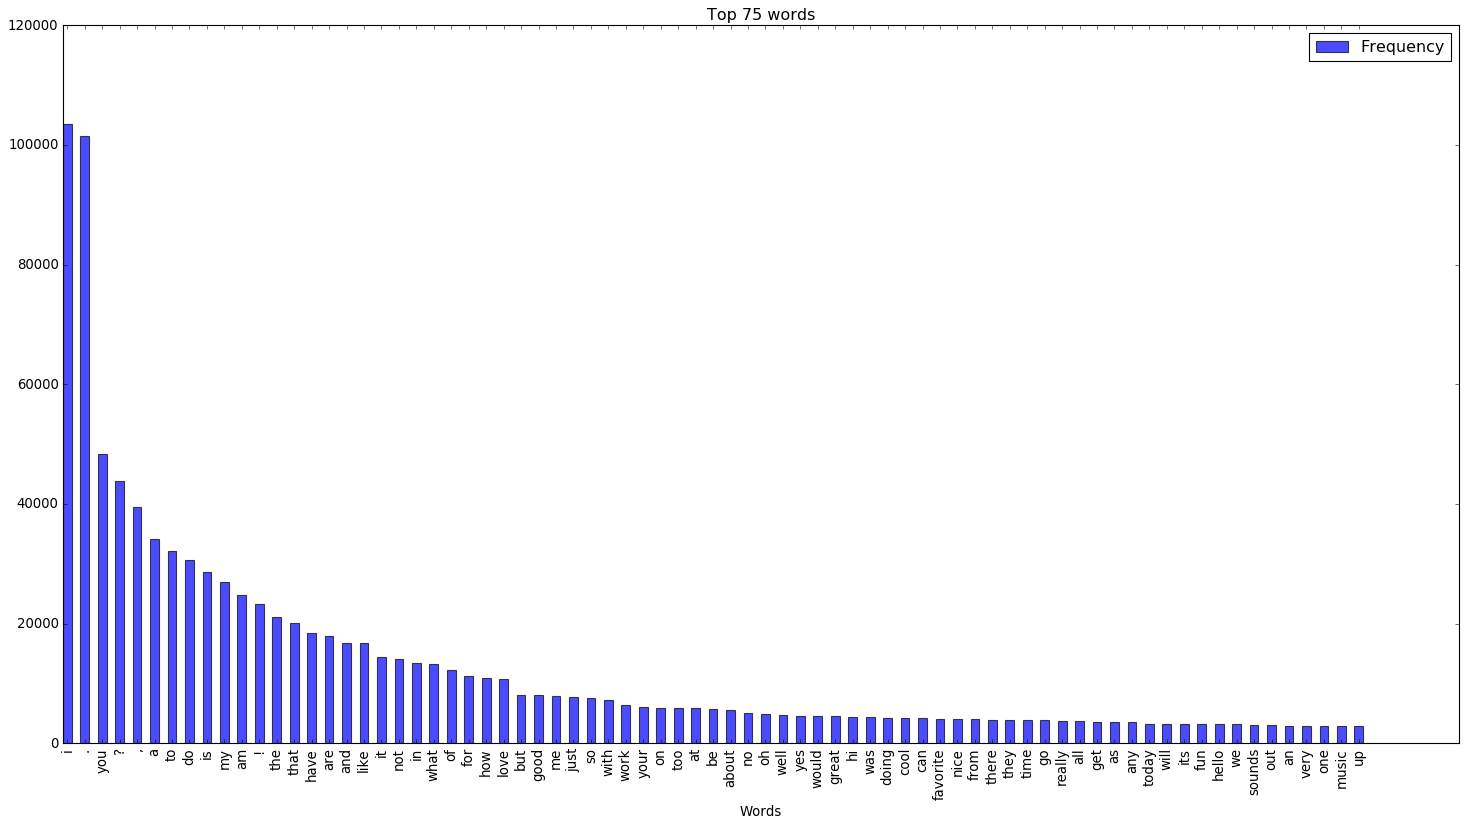

In [18]:
xs = np.arange(len(top))
ys = top.values()

bar_width = .5
opacity = 0.7
error_config = {'ecolor': '0.3'}


fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
fig.set_facecolor(color='white')


rects = ax.bar(xs, ys, width=bar_width,
               align='edge',
               alpha=opacity, color='b',
               error_kw=error_config,
               label='Frequency')

ax.set_xlabel('Words')
ax.set_title('Top 75 words')
ax.set_xticks(xs + bar_width / 2)
ax.set_xticklabels(top.keys())
ax.legend()

plt.xticks(rotation=90)
fig.tight_layout()


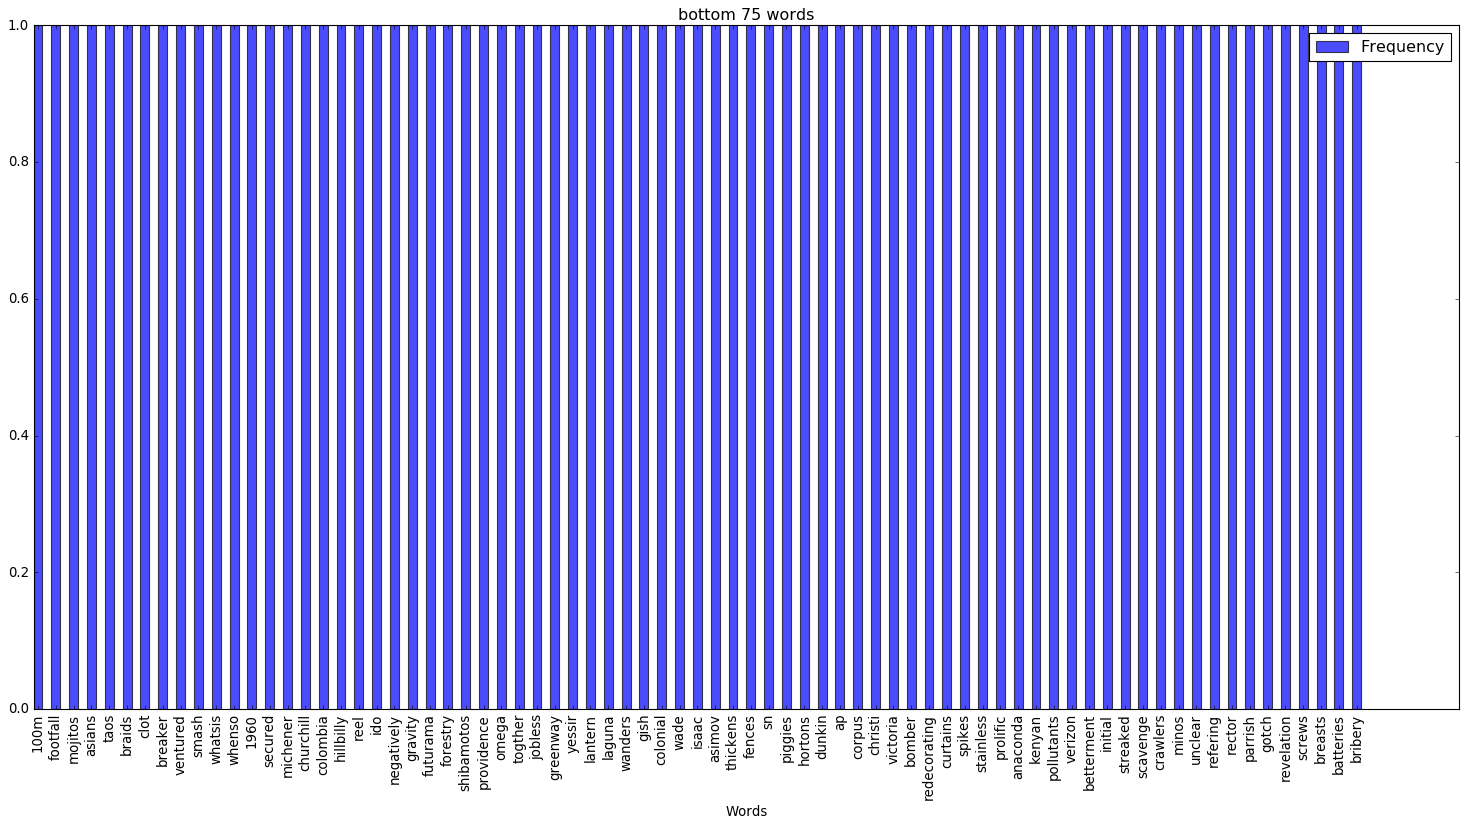

In [19]:
xs = np.arange(len(bottom))
ys = bottom.values()

bar_width = .5
opacity = 0.7
error_config = {'ecolor': '0.3'}

#plt.style.use('classic')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
fig.set_facecolor(color='white')


rects = ax.bar(xs, ys, width=bar_width,
               align='edge',
               alpha=opacity, color='b',
               error_kw=error_config,
               label='Frequency')

ax.set_xlabel('Words')
ax.set_title('bottom 75 words')
ax.set_xticks(xs + bar_width / 2)
ax.set_xticklabels(bottom.keys())
ax.legend()

plt.xticks(rotation=90)
fig.tight_layout()

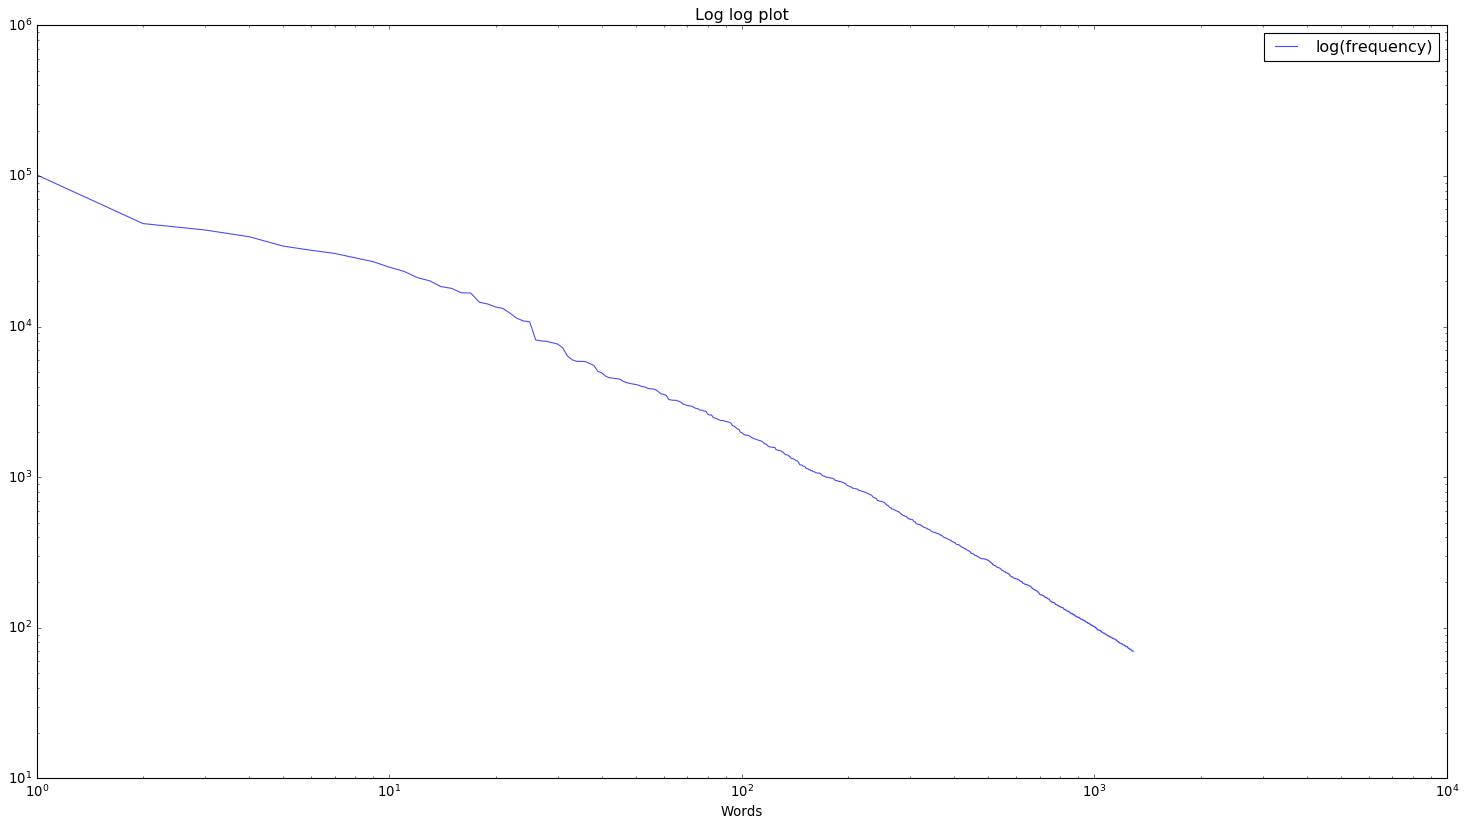

In [139]:
# Plot the loglog graph of the frequencies 

sort = OrderedDict(sorted(word_dic.items(), key=lambda kv: kv[1], reverse=True))

xs = np.arange(len(sort.keys()))
ys = sort.values()

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
fig.set_facecolor(color='white')

rects = ax.loglog(xs, ys, 
                alpha=opacity,
                color='b',
                label='log(frequency)')

ax.set_xlabel('Words')
ax.set_title('Log log plot')

ax.legend()

fig.tight_layout()

In [21]:
# How many words appear only once in the entire dataset ?
v = 1
values = np.array(list(word_dic.values()))
indices = np.where(values == v)
num = len(np.squeeze(indices))
print('there are {:d} words appearing only once in the entire dataset.'.format(num))

there are 7080 words appearing only once in the entire dataset.


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: 18673 - 1293 = 17'380 words have been removed (93.08%)

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: Original: 131424, Filtered: 58826

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: The generalization will be better because it will exclude rare words that probably was just occur in the training set and not in the test set.

In [22]:
# We keep only sentences where all word occurences in the
# dataset are above the predefined threshold
threshold = 70

In [23]:
# Update the vocabulary accordingly
dtype = np.dtype([('word','<U34'), ('frequency', int)])
word_array = np.array(list(word_dic.items()), dtype=dtype)
indices = np.squeeze(np.where(word_array['frequency'] >= threshold))

# new dictionary
freqword_dic = dict(word_array[indices])
# new array
freqword_array = word_array[indices]

In [24]:
freqword_set = set(freqword_dic.keys())
freqsentences = [s for s in sentences if set(s.split(separator)) <=  freqword_set]

In [25]:
fconversations = [[s for s in conv if set(s.split(separator)) <=  freqword_set] for conv in conversations]
freqsentences = [s for conv in fconversations for s in conv]

In [26]:
print('{:^30s} |{:^20s} |{:^20s}'.format('', 'Original', 'Filtered'))
print('{:^30s} |{:^20s} |{:^20s}'.format('-'*30, '-'*20, '-'*20))
print('{:30s} |{:^20d} |{:^20d}'.format('# words', len(word_dic.keys()), len(freqword_dic.keys())))
print('{:30s} |{:^20d} |{:^20d}'.format('# sentences', len(sentences), len(freqsentences)))
print('\n')


w_prop = 100 * (1 - len(freqword_dic.keys()) / len(word_dic.keys()))
s_prop = 100 * (1 - len(freqsentences) / len(sentences))
print('{:^30s} |{:^20s} |{:^20s}'.format('', 'percentage', '#'))
print('{:^30s} |{:^20s} |{:^20s}'.format('-'*30, '-'*20, '-'*20))
print('{:30s} |{:^20.2f} |{:^20d}'.format('suppresed words', w_prop, len(word_dic.keys()) - len(freqword_dic.keys())))
print('{:30s} |{:^20.2f} |{:^20d}'.format('suppresed sentences', s_prop, len(sentences) - len(freqsentences)))

                               |      Original       |      Filtered      
------------------------------ |-------------------- |--------------------
# words                        |       18673         |        1293        
# sentences                    |       131424        |       58826        


                               |     percentage      |         #          
------------------------------ |-------------------- |--------------------
suppresed words                |       93.08         |       17380        
suppresed sentences            |       55.24         |       72598        


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [27]:
word_dic, sentences = freqword_dic, freqsentences

In [28]:
# add the three artificial words
tokens = ['PADD'] + ['START'] + ['END'] + list(word_dic.keys())

No handles with labels found to put in legend.


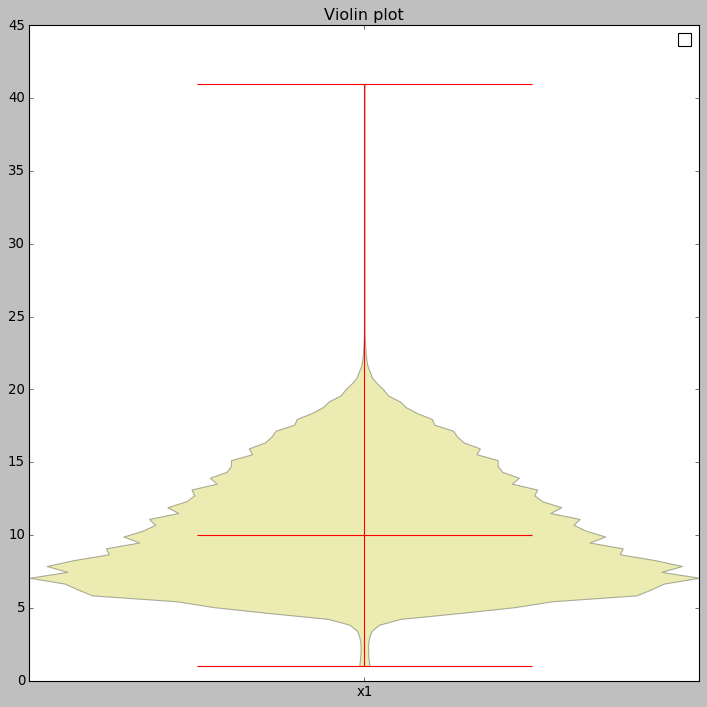

In [29]:
# Fixing random state for reproducibility
np.random.seed(19680801)
# lengths of sentences
xs = [len(s.split(separator)) for s in sentences]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
ax.set_title('Violin plot')
ax.set_xticks([1])
ax.set_xticklabels(['x1'])
ax.legend()

ax.violinplot(xs,
              showmeans=False,
              showmedians=True)
fig.tight_layout()
plt.show()

In [30]:
# create dictionary of mappings
dic = dict(zip(tokens, range(len(tokens))))
# translate every sentence to a list of integer
isentences = []
for s in sentences:
    ints = [tokens.index('START')]
    for word in s.split(separator):
        ints += [tokens.index(word)]
    isentences += [ints + [tokens.index('END')]] 

In [31]:
# padd sequences of integers
isentences = pad_sequences(isentences, 
                          maxlen=max(xs), 
                          dtype='int32', 
                          padding='post', 
                          truncating='post', 
                          value=0)
# padd sequences of strings
psentences = pad_sequences([s.split(separator) for s in sentences], 
                              maxlen=max(xs), 
                              dtype='<U34', 
                              padding='post', 
                              truncating='post', 
                              value='PADD')

psentences = np.apply_along_axis(lambda s: separator.join(s), 1, psentences).tolist()

In [32]:
isentences[:2]

array([[ 1,  7, 21, 22, 23, 24, 20, 25, 26, 27, 28, 29, 30, 31, 20,  2,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 41, 26, 46, 20, 15,  7, 47, 48, 30, 49, 36, 50, 28, 51,  9,
         2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [33]:
psentences[:2]

['you must be very fast . hunting is one of my favorite hobbies . PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD',
 'that is awesome . do you have a favorite season or time of year ? PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD']

In [34]:
def remove_flags_old(isentences):
    # mask padd values
    mask = ma.masked_where(isentences != 0, isentences)
    if np.any(np.logical_not(mask.mask)):
        # remove padd values
        isentences = isentences[mask.mask]
        # split on <START> => value = 1 (to recover original shape) 
        indices = np.where(isentences == 1)[0]
        # w/o padd
        isentences = np.split(isentences, indices)[1:]
    
    # remove <START>, <END> => [1, 2] values
    for i, s in enumerate(isentences):
        mask = np.isin(s, [1, 2])
        if np.any(mask):
            mask = np.logical_not(mask)
            isentences[i] = s[mask]
    return isentences

In [35]:
def remove_flags(isentences):
    # remove <PADD>, <START>, <END> => [0, 1, 2] values
    res = [0]*len(isentences)
    for i, s in enumerate(isentences):
        mask = np.isin(s, [0, 1, 2])
        res[i] = s
        if np.any(mask):   
            res[i] = s[np.logical_not(mask)]
    return res

In [36]:
# Used to convert sentances of tokens to sentances of words
def recover(isentences):
    # faster lookup
    dic_array = np.array(list(dic.items()), dtype=[('word','<U34'), ('id', int)])    
    # remove padding
    isentences = remove_flags(isentences)
    sentences = []
    for idx in isentences:
        sentences += [separator.join(dic_array['word'][idx])]
    return sentences

In [37]:
# Check that you can recover the original sentence.
n = len(isentences)
size = 2
selection = np.random.randint(n, size=size)

print(isentences[selection])
recover(isentences[selection])

[[   1  148   43   76  271  167   48 1092  832   20   35  148  118  335
    41   10   47  424    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   1   57   15    7   15   33   48   98    9    2    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


['it was fun even as a poor student . like it more now that i have money',
 'what do you do for a living ?']

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [38]:
import pickle
from pathlib import Path
from os.path import join

In [39]:
def save(filename, obj, save_path=Path('/mnt/storage01/mbanga/ann/save/')):
    pickle_out = open(join(save_path, Path(filename)), 'wb+')
    pickle.dump(obj, pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
    pickle_out.close()
    return True

In [40]:
def load(filename, save_path=Path('/mnt/storage01/mbanga/ann/save/')):
    pickle_in = open(join(save_path, Path(filename)), 'rb')
    obj = pickle.load(pickle_in)
    pickle_in.close()
    return obj

In [41]:
# name space
name_frequencies = 'data/train_both_revised/word_dic.pkl' # dictionary {word: frequency}
name_psentences = 'data/train_both_revised/psentences.pkl'
name_isentences = 'data/train_both_revised/isentences.pkl' 
name_dictionary = 'data/train_both_revised/dic.pkl' # dictionary {token: id}
name_sentences = 'data/train_both_revised/sentences.pkl'

In [42]:
# save data
save(name_frequencies, word_dic)
save(name_psentences, psentences)
save(name_isentences, isentences)
save(name_dictionary, dic)
save(name_sentences, sentences)

True

In [43]:
# load data
word_dic = load(name_frequencies)
psentences = load(name_psentences)
isentences = load(name_isentences)
dic = load(name_dictionary)
sentences = load(name_sentences)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** The embedding layer will mask the zeros and they will therefore be excluded from all the layers of the model. This means that 0 ('PADD') words will simply be ignored and instead, the previous word from the sentence will be outputted for each layer instead.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer** We can use the network to approximate the word transition probabilities by inputting a sentence to the network. The input for each batch will be a set of sentences that are shifted by one to the left (i.e the last element is excluded). The target will be a onehot encoded version of the sentences shifted by one to the right (i.e the first element is excluded). Also the more data, training examples the better the approximation of the transition probabilities.

The dimension of the input for a batch will be (batch_size, sentence_length-1) = (128, 40) and the output for each batch will be (batch_size, sentence_length-1, number_of_words) = (128, 40, 1296). For the dataset the dimensions will be (number_of_sentences, sentence_length-1), (number_of_sentences, sentence_length-1, number_of_words).

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

Done

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

Done

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: 

-  metrics:   [loss, accuracy]
-  LSTM:      [2.778256505170431, 0.4196105403423471] 
-  GRU:       [2.7833813668432303, 0.41909046023729424] 
-  SimpleRNN: [2.839411127611878, 0.40946852775789044]

GRU and LSTM seem have better performance with regards to test accuracy and loss than the SimpleRNN. However, SimpleRNN requires less time to learn and is the fastest learner. LSTM and GRU have similar scores, but from the plot, the GRU model seems to overfit less than the LSTM. Hence, we think GRU is the best model.

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: Yes, there is an overfitting effect. After around 5-10 epochs the validation loss is higher than the training loss for all the models. One reason that the data set starts to overfit is because the model is to flexible compared to the size of the dataset. So the model starts to remember the input-output mapping for each datapoint. Also there might be to little data compared to the expressive power of the model.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: One way to reduce the overfitting effect would be to either decrease the number of "rare" words. In this case the network will not try to model the outliers as much. Another way would be to increase the size of the dataset through data augumenation, were new sentences are generated. For example, we could create new sentances by replacing words with one of its synonyms.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: One way to modify the network to decrease overfitting would be to reduce the number of neurons in each layer. This will make the flexibility of the network decrease. This could be done either in the readout layer or the recurrent layer.

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: We could for example increase the value of the dropout variable. If we want to reduce the dependancies of past data we could also increase the recurrent_dropout variable.

In [44]:
from keras.utils import plot_model, to_categorical, multi_gpu_model
from keras.layers import Flatten
from math import ceil

In [45]:
#Meta-parameters
maxlen = 41
embedding_size = 128
hidden_size = 64
dropout = 0.2
recurrent_dropout = 0.2

batch_size = 128
epochs = 32
validation_split = 0.2

dataset_cut = int(.1 * len(isentences))

In [46]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [47]:
def batch_iter(x, batch_size, num_batches=1):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input one iterable (here the file names of the articles)
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `x`.
    Example of use :
    for minibatch_filenames, in batch_iter(x, 2):
        <DO-SOMETHING>
    """
    data_size = len(x)

    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield x[start_index:end_index]

In [48]:
def prepare_data(isentences, split=.1):
    n = len(isentences)
    cut = int(split * n)
    
    y = []  
    for s in isentences:
        y += [to_categorical(s[1:], len(tokens))] # convert to one hot encoding
    
    x = isentences[:, :-1] # remove last column
    y = np.array(y)
#     y = to_categorical(isentences[:, 1:], len(tokens)) # takes hours
      
    # Separate train and validation
    x_train, x_test = x[cut:], x[:cut]  
    y_train, y_test = y[cut:], y[:cut]

    return (x_train, y_train), (x_test, y_test)

In [49]:
hiddens = [['RNN', 'LSTM', 'GRU'], [SimpleRNN, LSTM, GRU]]

In [50]:
# Get data
(x_train, y_train), (x_test, y_test) = prepare_data(isentences)

In [47]:
for name, layer in list(zip(*hiddens)):
    print('{:s} {:s}...'.format('running', name))
    # Input
    I[name] = Input(shape=(maxlen-1,), name="input")

    # Transform every character into a 128-dimensional vector:
    E[name] = Embedding(len(dic), embedding_size, mask_zero=True, name="embedding")
    # The RNN layer with dropout
    H[name] = layer(hidden_size, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(E[name](I[name]))
    # The readout layer
    R[name] = TimeDistributed(Dense(embedding_size, activation='sigmoid'))(H[name])        
    # The output layer 
    Y[name] = TimeDistributed(Dense(len(dic), activation='softmax'))(R[name])       
    # The model
    models[name] = Model(inputs = I[name], outputs = Y[name])    
           
    models[name].compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(),
        metrics=['acc'])
    models[name].summary()

    logs[name] = models[name].fit(x_train, y_train, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history
    

running RNN...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 40)                0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 128)           165888    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40, 64)            12352     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           8320      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 40, 1296)          167184    
Total params: 353,744
Trainable params: 353,744
Non-trainable params: 0


42355/42355 [==============================] - 45s 1ms/step - loss: 3.0961 - acc: 0.3892 - val_loss: 3.0671 - val_acc: 0.3946
Epoch 7/32
42355/42355 [==============================] - 45s 1ms/step - loss: 3.0391 - acc: 0.3945 - val_loss: 3.0208 - val_acc: 0.3998
Epoch 8/32
42355/42355 [==============================] - 44s 1ms/step - loss: 2.9941 - acc: 0.3988 - val_loss: 2.9854 - val_acc: 0.4033
Epoch 9/32
42355/42355 [==============================] - 45s 1ms/step - loss: 2.9562 - acc: 0.4025 - val_loss: 2.9539 - val_acc: 0.4072
Epoch 10/32
42355/42355 [==============================] - 47s 1ms/step - loss: 2.9243 - acc: 0.4052 - val_loss: 2.9286 - val_acc: 0.4087
Epoch 11/32
42355/42355 [==============================] - 46s 1ms/step - loss: 2.8977 - acc: 0.4077 - val_loss: 2.9083 - val_acc: 0.4107
Epoch 12/32
42355/42355 [==============================] - 45s 1ms/step - loss: 2.8739 - acc: 0.4100 - val_loss: 2.8906 - val_acc: 0.4124
Epoch 13/32
42355/42355 [========================

In [51]:
# name space
nameLayer = 'models/layer.pkl'
nameModel = 'models/model.pkl'
nameLog = 'models/log.pkl'

In [52]:
# load
# layers = load(nameLayer)
models = load(nameModel)
logs = load(nameLog)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/home/mbanga/.conda/envs/ann/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
/home/mbanga/.conda/envs/ann/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [53]:
# Used for testing purpose
def viz(ix, iy, iyHat):
    # recover string representation
    syHat = recover(iyHat[:, None])
    sy = recover(iy[:, None])
    sx = recover(ix)
    
    print('{:^75s} |{:^15s} |{:^15s}'.format('input', 'target', 'prediction'))
    print('{:^75s} |{:^15s} |{:^15s}'.format('-'*75, '-'*15, '-'*15))
    
    for i, v in enumerate(zip(sx, sy, syHat)):
        input_, target, pred = v
        print('{:75s} |{:^15s} |{:^15s}'.format(input_, target, pred))
        if i == 100: 
            break

In [54]:
# Used for testing purpose
def accuracy(model, ix, hy, show=True):
    # target: change one hot encoding back to integer
    iy = np.apply_along_axis(np.argmax, 1, hy)
    # compute predictions
    hyHat = model.predict(ix)
    # prediction: change one hot encoding back to integer
    iyHat = np.apply_along_axis(np.argmax, 1, hyHat)
    
    n_samples = len(iy)
    n_errors = len(np.nonzero(iy - iyHat)[0])
    # simple viz
    viz(ix, iy, iyHat) if show else None
        
    return 1 - n_errors / n_samples

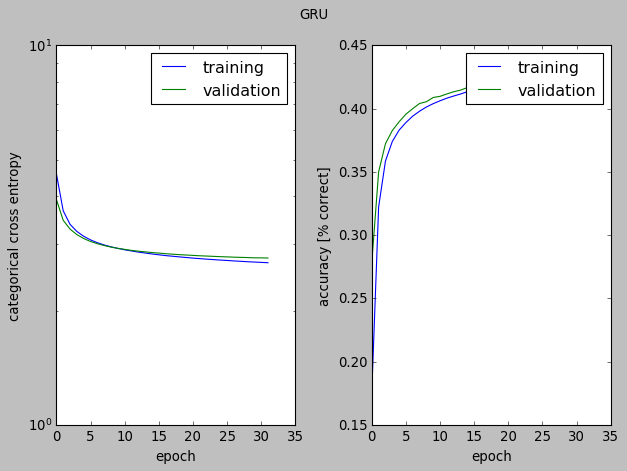

In [55]:
#Plot GRU history
name = 'GRU'
plot = plot_history(logs[name], name)

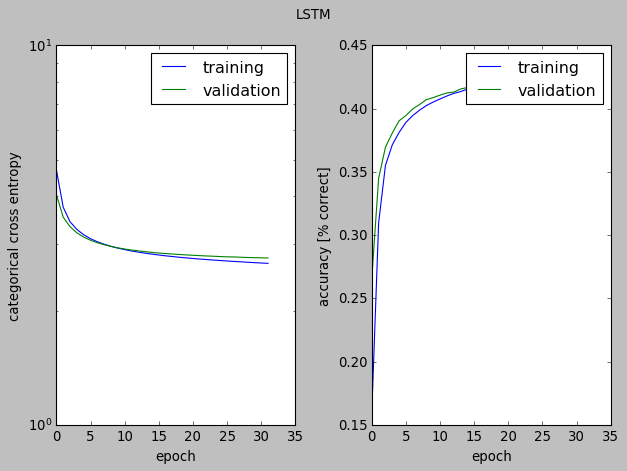

In [56]:
#Plot LSTM history
name = 'LSTM'
plot = plot_history(logs[name], name)

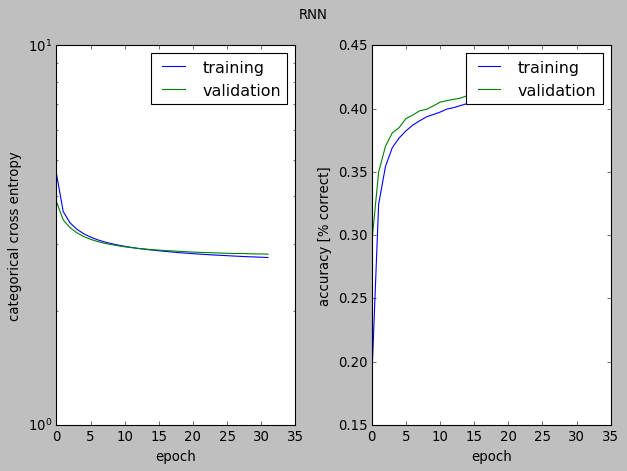

In [57]:
#Plot SimpleRNN history
name = 'RNN'
plot = plot_history(logs[name], name)

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**  The difference between the validation and training error is bigger for the 256GRU compared to all other models. It seem like there is a pattern where the bigger the model, the bigger the validation error and the training error is diverges. One exception is the 2x64 GRU model, which has less divergence between the training error and the validation error.

Looking at the accuracy, all the model looks similar. However, the 256 GRU models validation accuracy seems to be less smooth and more stochastic

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** Early stopping seems to make the model stop when it's very close to the training accuracy. This is that the training will stop earlier, so we don't need train for as long time. One drawback with this is that we cannot be sure that it stops where the validation error is the best. In other words, it might be the case that the validation error increases after the early stopping ends.

**Question** What is your best model? Why? [1 pt]

**Answer** It looks like the best model is the 256 GRU model since it has the highest validation and training accuracy.


In [58]:
def build_finetune_model(best, new, conf):
    # The input layer
    I[new] = I[best]
    # Transform every character into a 128-dimensional vector
    E[new] = E[best]
    
    # first hidden layer
    h = GRU(conf[0], activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(E[new](I[new]))
    rec = [h]
    for i in range(1, len(conf)):
        n_units = conf[i]
        h = GRU(n_units, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(rec[-1])
        rec += [h]
        
    # The recurrent layer with dropout
    H[new] = rec
    # The readout layer
    R[new] = TimeDistributed(Dense(embedding_size, activation='sigmoid'))(H[new][-1])        
    # The output layer 
    Y[new] = TimeDistributed(Dense(len(dic), activation='softmax'))(R[new])       
    # The model
    models[new] = Model(inputs = I[new], outputs = Y[new])
    models[new] = multi_gpu_model(models[new], gpus=2)
    
    # freeze up to embedding layer
    I[new].trainable = False
    E[new].trainable = False
    
    return models[new]

In [59]:
# define the patience for EarlyStopping
patience = 2
# Define Early Stopping Callback
es = EarlyStopping(monitor='val_loss', verbose=1, patience=patience, min_delta=0.001)

In [60]:
configurations = [[64], [128], [256], [64, 64]]
best = 'GRU'

In [61]:
def conf_name(conf, layer='GRU'):
    name = '{}_' * (len(conf) + 1)
    name = name.format(layer, *conf)
    return name[:-1]

In [60]:
# Fit all the models
for conf in configurations:
    name = conf_name(conf)
    # Get model
    model = build_finetune_model(best, name, conf)

    model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
    model.summary()

    
    logs[name] = model.fit(x_train, y_train, 
                           epochs=epochs, 
                           validation_split=validation_split, 
                           batch_size=batch_size, callbacks=[es]).history

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 40)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 40)           0           input[0][0]                      
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 40)           0           input[0][0]                      
__________________________________________________________________________________________________
model_4 (Model)                 (None, 40, 1296)     378448      lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

42355/42355 [==============================] - 43s 1ms/step - loss: 2.6311 - acc: 0.4382 - val_loss: 2.7117 - val_acc: 0.4346
Epoch 19/32
42355/42355 [==============================] - 43s 1ms/step - loss: 2.6221 - acc: 0.4387 - val_loss: 2.7084 - val_acc: 0.4344
Epoch 20/32
42355/42355 [==============================] - 43s 1ms/step - loss: 2.6136 - acc: 0.4394 - val_loss: 2.7055 - val_acc: 0.4354
Epoch 21/32
42355/42355 [==============================] - 42s 988us/step - loss: 2.6054 - acc: 0.4404 - val_loss: 2.7009 - val_acc: 0.4358
Epoch 22/32
42355/42355 [==============================] - 43s 1ms/step - loss: 2.5978 - acc: 0.4413 - val_loss: 2.6977 - val_acc: 0.4361
Epoch 23/32
42355/42355 [==============================] - 44s 1ms/step - loss: 2.5908 - acc: 0.4422 - val_loss: 2.6944 - val_acc: 0.4368
Epoch 24/32
42355/42355 [==============================] - 42s 995us/step - loss: 2.5842 - acc: 0.4425 - val_loss: 2.6920 - val_acc: 0.4371
Epoch 25/32
42355/42355 [=================

In [155]:
# load
# layers = load(nameLayer)
#models = load('nameModel')
#logs = load(nameLog)

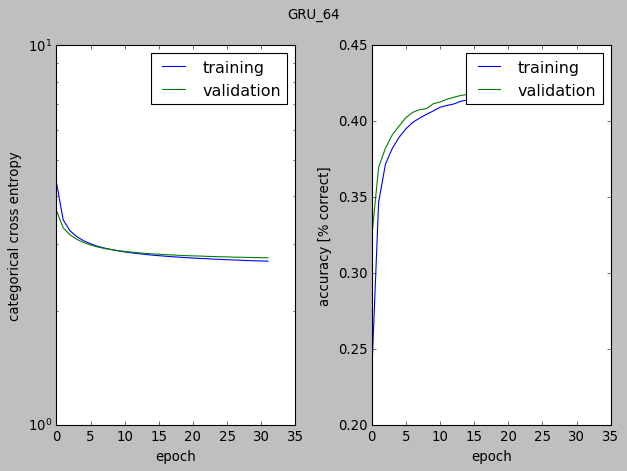

In [62]:
#Plot GRU_64 history
name = 'GRU_64'
plot = plot_history(logs[name], name)

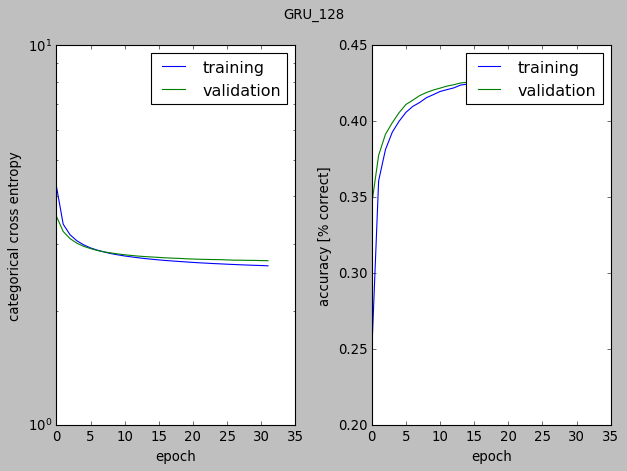

In [63]:
#Plot GRU_128 history
name = 'GRU_128'
plot = plot_history(logs[name], name)

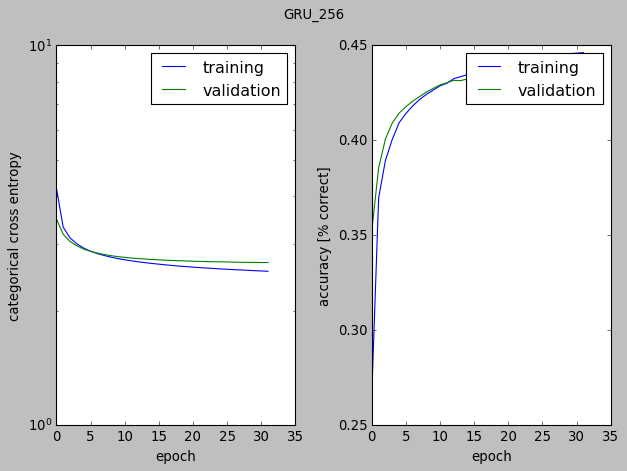

In [64]:
#Plot GRU_256 history
name = 'GRU_256'
plot = plot_history(logs[name], name)

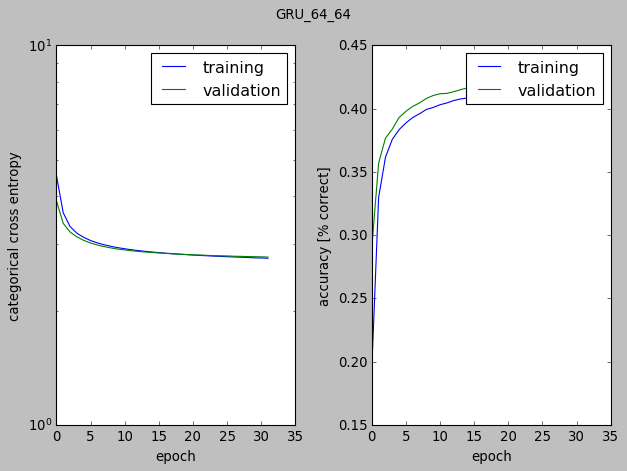

In [65]:
#Plot GRU_64_64 history
name = 'GRU_64_64'
plot = plot_history(logs[name], name)

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Temperature determines how randomly the next word in the sentence should be chosen. It affects the probability for a word to be chosen.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** If the sampling temprature is 0, there is no randomness involved, and the the word will highest probability will be selected.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer** If the sampling temprature is 1, then the probabilities in the prediction array will not change because exp(ln(p)/1) = p. Said differently, a word will be selected randomly with a probability that equals to the value for the word in the prediction array.

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** There is a higher chance that the words with low probability is chosen. I.e the words are chosen more or less uniformly. In other words, the probabilties converges to same value (i.e uniform distribution). So words will get the same probability of being chosen regardless of the initial probabilities.

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** A sentence is generated by randomly chosing a word from the probability distribution. This word is then added to the sentence, and a new probability distrubiton is calculated again from the model and the process is repeated again.

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** Yes, for example ',' and 'i' seem to have similar probabilities in the sentence: 'yea , i bet i have never been working out for twins'. This is logical, because both 'yea i ' and 'yea , ' could be correct sentences. In terms of language, this means that the words are related and could therefore both be used to possibly be a meaningful sentence.

In [152]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds)
    return np.argmax(probas)


In [164]:
def generate_sentance(name, temperature=1., sentance = []):
    
    unique, counts = np.unique(sentance, return_counts=True)
    counts = dict(zip(unique, counts))
    
    for x in range(counts[0]):
        # Predict the probabilties next possible words
        yHat = models[name].predict(sentance)
        # Randomly sample a token
        sampled_token = sample(yHat[0][x],1)
        # Stop generating a sentance if sampling the END token
        if (sampled_token == 2):
            #print("END OF SENTANCE")
            break
        sentance[0][x+(len(sentance[0])-counts[0])] = sampled_token
    return sentance

temp = 0.1 :



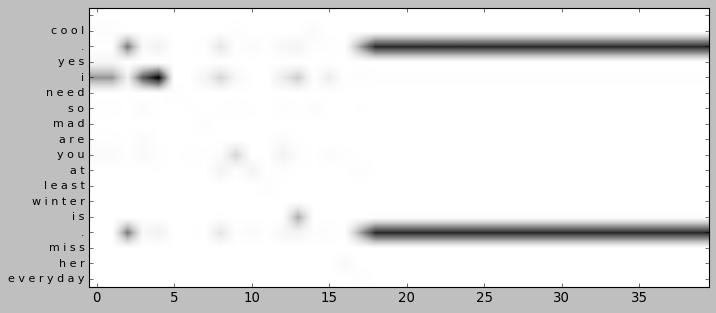

['cool . yes i need so mad are you at least winter is . miss her everyday']
['thank you . do you have any kids ?']
['that is good state . . . and all day lol']
['what else do you do ?']
['you should beat me one . would not you be around me .']
['what is new any of your dreams ? i do not like meat either']
['i have time to drive . i do like sports , they are twins right now .']
['you are a writer ? where do you like to shop ?']
['i am doing ok really']
['interesting . do you have any pets ?']
temp = 0.25 :



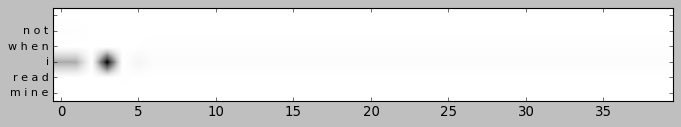

['not when i read mine']
['i have never had work before . we miss them ha']
['thanks ! the only thing i drive is my favorite though']
['i love movies , i can imagine why you play baseball ?']
['tell me more about yourself']
['i can sing you have chicken']
['i live a full time ago too']
['i do not also eat any chocolate . but i like traveling when its over with my 3 cats .']
['hey how are you doing ?']
['i do not work but i am a vegan']
temp = 0.5 :



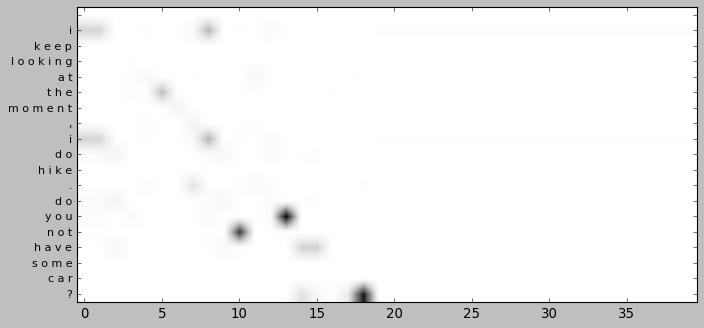

['i keep looking at the moment , i do hike . do you not have some car ?']
['they are pretty great ! hello ! i am well !']
['i am from california . where are you from ?']
['like her but love football and chinese food . you ?']
['that would be interesting . what do you do ?']
['oh ok what are you talking to ?']
['never thought you try great to come with me .']
['i do not have time teaching is hard . tennis is a good thing .']
['okay ! where are you from ?']
['i wanna make a mom and they were safe with my two kids .']
temp = 0.75 :



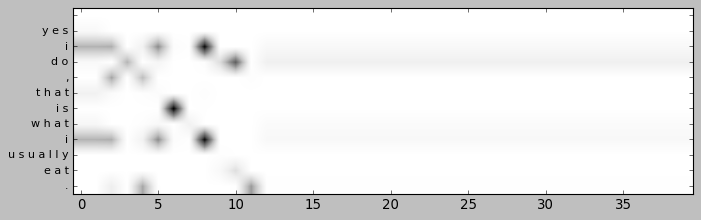

['yes i do , that is what i usually eat .']
['what do you do for a living ?']
['do you want to make money ?']
['it is busy ! i have been dancing to my girlfriend who i love it !']
['definitely you can take it there once top for the eye']
['good morning . my favorite thing is winter']
['i do not have much much time sometimes']
['my 6 brothers are a lawyer , she is stressful .']
['me too ! mainly dogs and pool ! i have always wanted to go there !']
['probably did not have that tattoos either love my life .']
temp = 1 :



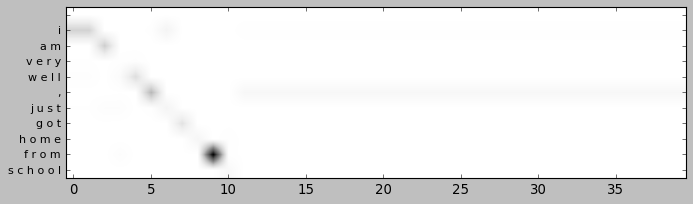

['i am very well , just got home from school']
['that is a good place to get business']
['you are right now , i am sorry']
['hello there , how are you ?']
['i do not really have any kids . i love cooking and good candy']
['that is good sounds work']
['some one has so much about mine so i don take care of my kids']
['i love all kinds of more']
['how are you doing today']
['oh nice . what kind of music ? . i love going out to read crime . best food ever .']
temp = 1.5 :



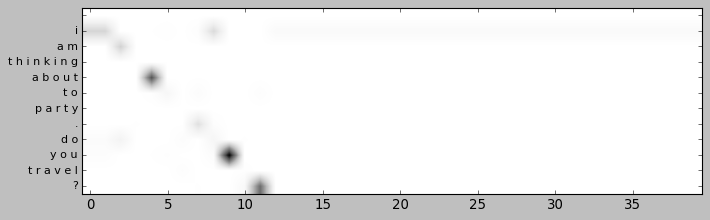

['i am thinking about to party . do you travel ?']
['oh no , that is smart . are you for a girl ? i have had tv much .']
['where are you from ? it was all fun . good luck . you ?']
['hi i am doing great i love to read']
['yeah she loves him out .']
['fine i like to go to alabama']
['i am sorry to you miss her']
['that is ok . what color are your eyes ? mine is purple']
['so what kind of doctor do you have ?']
['oh , i am 30 and you ?']
temp = 2 :



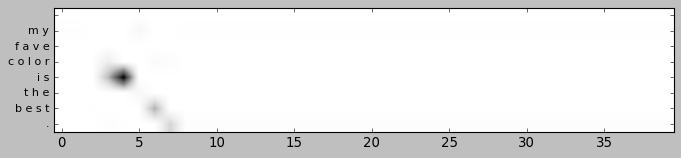

['my fave color is the best .']
['what has your favorite book ?']
['well i just graduated from nursing work']
['ll a lot in what others do . i know italian . do you like it ?']
['do you like to listen to music ?']
['hey going to get chatting with bacon']
['sounds like fun ! i like painting and draw .']
['it is ok i am fresh at the restaurant . i like dogs .']
['hello how are you doing']
['hi ! i am doing ok , where are you from ?']


In [163]:
#Generate sentances for different tempratures

temps = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2]
name = 'GRU_256'

for temp in temps:
    print("temp =",temp , ":")
    for x in range(10):
        start_sentance = np.array([1] + [0]*39)[None, :]
        sentance = generate_sentance(name, temp, start_sentance)
        
        if x == 0:
        # Plot image:
            new_sentance = np.array([1] + [0]*39)[None, :]
            image = []
            i = 0
            words = []
        
            for word in sentance[0]:
                yHat = models[name].predict(new_sentance)
                probs = []
                if word != 0:
                    words.append(recover([word])[0])
                
                for word2 in sentance[0]:
                    if word2 != 0:
                        probs.append(yHat[0][i][word2])
                new_sentance[0][i] = word
                i += 1
                image.append(probs)
                
            print()    
            fig, ax = plt.subplots(figsize=(10, 100))
            ax.imshow(np.array(image).transpose(), cmap='Greys')
            ax.set_yticks([i for i in range(len(words))])
            ax.set_yticklabels(words,fontsize=10)
            plt.show()
        
        print(recover(sentance))         

In [165]:
temp = 2
recoveries = []

for i in range(10):
    start = np.array([1 ,171 ,254, 99, 1015] + [0]*35)[None, :]
    s = generate_sentance(name, temp, start)
    recoveries += recover(s)
recoveries

['at least the bar that alabama you guys i good gives ever need be',
 'at least the bar i the you best or listen',
 'at least the bar hi this what group is how fall was ? for ? there you',
 'at least the bar i a you world of am cat',
 'at least the bar it a you computer goes was little is is ! . , men why',
 'at least the bar i least you age an am can like . amazing not the pizza',
 'at least the bar i least you outdoors is got be ask no fun time a you',
 'at least the bar yes the you new so i eggs ! york ? recently on',
 'at least the bar do times i time a you college have ! lot outside',
 'at least the bar i least haha beach is am think']

In [70]:
temp = 2
recoveries = []

for i in range(10):
    start = np.array([1, 41, 26, 92] + [0]*36)[None, :]
    s = generate_sentance(name, temp, start)
    recoveries += recover(s)
recoveries

['that is good that is good , you interesting i not must as love really be a',
 'that is good i sounds absolutely . never good hard i played with to am those new run outside growing toes .',
 'that is good he sounds alright kind is nice',
 'that is good sitting is pretty i of very early feel taking long',
 'that is good no is something , we it being you have moved way home extra there .',
 'that is good i is great . know not . i there as it like found one depends me in . there out a',
 'that is good hello is a . . there tough nice . is . times what math you a i do do week bought',
 'that is good i is really , really all old congratulations good of ,',
 'that is good yes is okay . i into now you do to , do not travel but you know ? mostly hate that',
 'that is good just is cool . getting always getting what ready busy mad you in . haha think !']

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

Yes, for example:

- and, or (Logical connectives)
- haha, lol (Laughing words)
- fun, awesome, interesting, great, nice (Adjectives descriping how good something is)
- now, sometimes (Temporal words)

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** We want them to have similar vector representation because we want the network to treat them similarly. If they have similar vector representations, that means that they are closer to each other in space. Because of this it's possible to create hyperplanes that seperate them into clusters. In this way, there will be less overfitting because similar words will be in the same cluster. This means that the region needed to classify these words will be smaller and therefore there will be less chance that other words not supposed to be in the region get missclassified.

In [71]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [72]:
# Get the top 200 words
top = OrderedDict(sorted(word_dic.items(), key=lambda kv: kv[1], reverse=True)[:200])

top_words = []
top_tokens = []

for w in top.keys():
    top_words += [w]
    top_tokens += [dic[w]]

arr = np.array(top_tokens)
x_input = np.array([arr[:40], arr[40:80],arr[80:120],arr[120:160],arr[160:200]])


In [73]:
name = 'GRU'

In [74]:
# Create the model using the trained embedding layer for mapping tokens to vectors:
MyInput = Input(shape=(maxlen-1,), name="input")
MyEmbedding = models[name].layers[1](MyInput)

model = Model(MyInput, MyEmbedding)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
model.summary()

# Predict
y = model.predict(x_input)

# Concatinate the outputs
coordinates = np.concatenate((y[0],y[1],y[2],y[3],y[4]))

# Perform dimensionailty reduction.
X = np.array(coordinates)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 40)                0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 128)           165888    
Total params: 165,888
Trainable params: 0
Non-trainable params: 165,888
_________________________________________________________________


array([[ 6.61194503e-01,  6.28720427e+00],
       [ 8.59423256e+00, -4.14017534e+00],
       [ 4.87616032e-01,  4.25633144e+00],
       [ 8.61606121e+00, -4.15099096e+00],
       [ 4.13325405e+00, -3.01719952e+00],
       [ 1.89436936e+00,  9.20237637e+00],
       [-1.20183706e+01,  3.31167555e+00],
       [-1.02145500e+01,  7.29267883e+00],
       [-6.75764847e+00,  6.70557404e+00],
       [ 1.23562622e+00,  9.95905018e+00],
       [-5.29913425e+00,  5.64184189e+00],
       [ 8.56308365e+00, -4.13415718e+00],
       [ 1.59818244e+00,  9.37805080e+00],
       [ 1.42526019e+00,  3.30522466e+00],
       [-8.65489197e+00,  4.63411093e+00],
       [-7.41410398e+00,  6.63449097e+00],
       [ 1.09317243e+00, -3.37965775e+00],
       [-1.00017605e+01,  1.31526515e-01],
       [ 7.87126720e-01,  2.94558263e+00],
       [-2.28618431e+00,  8.34989548e+00],
       [-1.06332197e+01, -2.08913350e+00],
       [ 4.83930588e+00,  4.07838345e+00],
       [-1.04497347e+01,  9.80375290e-01],
       [-1.

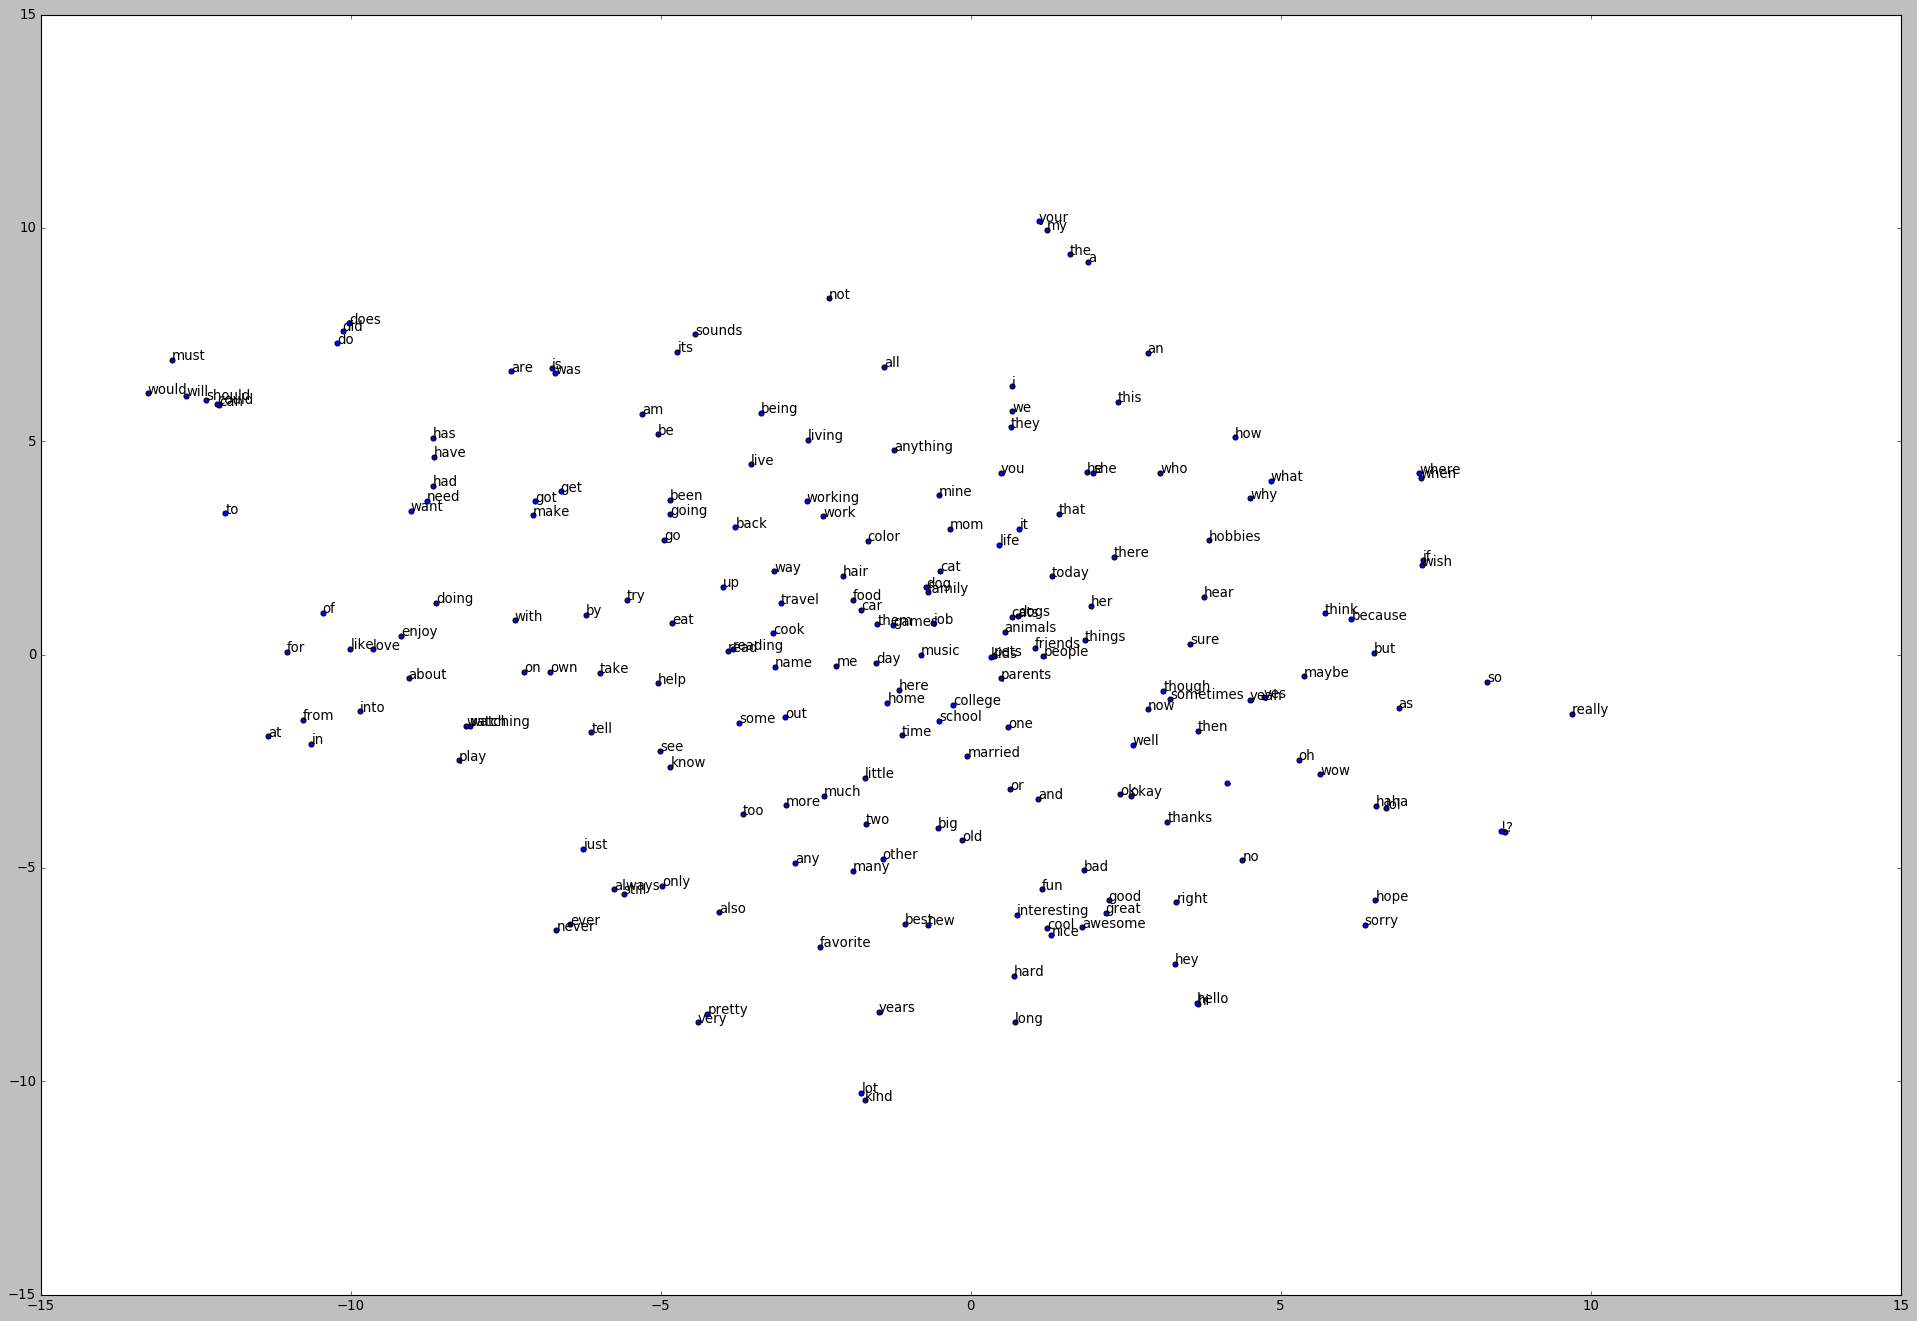

In [108]:
import matplotlib.pyplot as plt

# Convert coordinates into two list of x and y values.
x_ = []
y_ = []

for coordinate in X_embedded:
    x_.append(coordinate[0])
    y_.append(coordinate[1])
    
#Plot
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter(x_, y_)

for i, txt in enumerate(top_words):
    ax.annotate(txt, (x_[i], y_[i]))

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer** The sentences are not very similar to the real once. It seems like the generated answers are more generic reponses, especially for the sentences generated with temperature equal to 1. It seems like they are not so dependant on the context in this case. This is probably because of the randomness effect in the sampling method. But also because only one sentence from the conversation is provided, and therefore context is reduced.

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer** It looks like lower temprature give better answers. This is because with lower tempratures, the probability that the word with highest probabiliy is chosen gets higher.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** No, if it would reproduce the real exactly, this means that it would probably be overfitted to the data, as there is usually several similar responses to an answer

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [76]:
# Create pairs
pairs = []
valid_words = set(dic.keys())
for conv in conversations:
    for question, answer in zip(conv[:-1], conv[1:]):
        words = question.split(separator) + answer.split(separator)
        if set(words) <= valid_words:
            pairs += [[question, answer]]    

In [77]:
pairs[0]

['hi , how are you doing today ?',
 'i am spending time with my 4 sisters what are you up to']

In [78]:
# Tokenize (question, answer) pairs
def tokenize(sequence, artificial=False):
    isequence = []
    for word in sequence:
        isequence += [dic[word]]
    if artificial:
        isequence = [dic['START']] + isequence + [dic['END']]
    return isequence

In [79]:
# Convert pairs into answrs and question arrays
ipairs = []
ianswers = []
iquestions = []

for question, answer in pairs:
    iquestion = tokenize(question.split(separator), artificial=False)
    ianswer = tokenize(answer.split(separator), artificial=True)
    ipairs += [[iquestion, ianswer]]
    ianswers += [ianswer]
    iquestions += [iquestion]

In [80]:
ipairs[0]

[[3, 4, 5, 6, 7, 8, 68, 9],
 [1, 10, 11, 81, 50, 82, 29, 83, 84, 57, 6, 7, 85, 14, 2]]

In [81]:
# padd (question, answer) pairs
ipairs = pad_sequences([s for sub in ipairs for s in sub], 
                       maxlen=max(xs), 
                       dtype='int32', 
                       padding='post', 
                       truncating='post', 
                       value=0)

ipairs = list(zip(ipairs[0::2], ipairs[1::2]))

iquestions = pad_sequences(iquestions, 
                       maxlen=maxlen-2, 
                       dtype='int32', 
                       padding='post', 
                       truncating='post', 
                       value=0)

ianswers = pad_sequences(ianswers, 
                       maxlen=maxlen, 
                       dtype='int32', 
                       padding='post', 
                       truncating='post', 
                       value=0)

In [82]:
ipairs[0]

(array([ 3,  4,  5,  6,  7,  8, 68,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([ 1, 10, 11, 81, 50, 82, 29, 83, 84, 57,  6,  7, 85, 14,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], dtype=int32))

In [83]:
recover(ipairs[0])

['hi , how are you doing today ?',
 'i am spending time with my 4 sisters what are you up to']

In [84]:
len(iquestions)

26057

In [85]:
# Output answers shifted by 1 to the right that are one-hot encoded
out_y = to_categorical(ianswers[:,1:])
# Input answer sentances shifted by 1 to the left
input_x = ianswers[:,:-1]

In [86]:
name = 'Chatbot'

In [102]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = E['GRU']
context_embedding = shared_embedding(context)

# Get output y, output h and the old memory c from the LSTM memory unit.
encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

# Train the model with the context (Vector encoded form of the question) as the initial_state. 
answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])

# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

models[name] = Model(inputs = [context, answer], outputs = [Y])

Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()

logs[name] = Chatbot.fit([iquestions, input_x], out_y, epochs=epochs, 
                                validation_split=validation_split, 
                                batch_size=batch_size).history

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 40)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 39)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             165888      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[5][0]                  
__________

In [ ]:
# load
models = load(nameModel)
logs = load(nameLog)

In [87]:
import matplotlib.image as mpimg

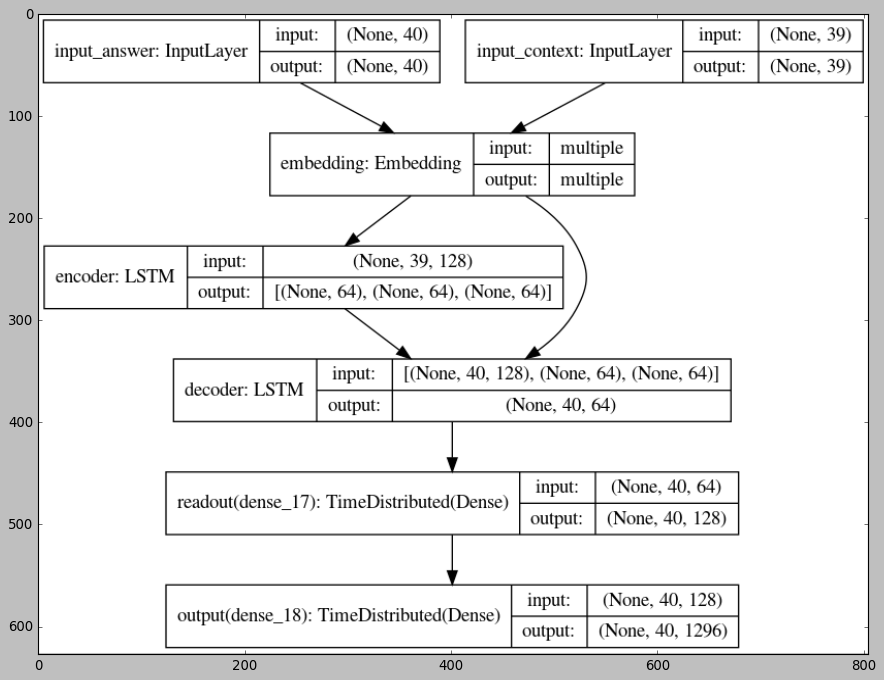

In [88]:
# Plot the model
plot_model(models[name], to_file='Chatbot_model.png', show_shapes=True)

img = mpimg.imread('Chatbot_model.png')
fig, ax = plt.subplots(figsize=(13.4, 10))
ax.imshow(img)
ax.set_aspect('auto')
plt.show()

In [97]:
def generate_sentance_new(name, temperature=1., context = [], answer = []):
    
    for x in range(38):
        # Predict the probabilties next possible words
        yHat = models[name].predict([context, ans])
        # Randomly sample a token for current word
        sampled_token = sample(yHat[0][x],temperature)
        # Stop generating a sentance if sampling the END token
        if (sampled_token == 2):
            #print("END OF SENTANCE")
            break
        answer[0][x+1] = sampled_token
    return answer

In [98]:
# Testing
ctx = np.array([iquestions[0]])
ans = np.array([np.array([1] + [0]*39)])

sentance = generate_sentance_new(name, 1,ctx,ans)

print(recover(ctx))
print(recover(sentance))

['hi , how are you doing today ?']
['chatting lovely agree spend halloween feel very band fresh part arm types girls languages just why concert we gets sports awful back chat couch beat 18 before camping ex selling design late their very running mountain doctor again']


In [110]:
ten_random = np.random.randint(len(iquestions), size=10)

print("temp = 0: \n")
for n in ten_random:
    ctx = np.array([iquestions[n]])
    ans = np.array([np.array([1] + [0]*39)])
    sentance = generate_sentance_new(name, 0,ctx,ans)
    
    print("question: ",recover(ctx)[0])
    print("predicted answer: ", recover(sentance)[0])
    print("real answer: ", recover(np.array([ianswers[n]]))[0])
    print("\n")

print("temp = 0.5: \n")
for n in ten_random:
    ctx = np.array([iquestions[n]])
    ans = np.array([np.array([1] + [0]*39)])
    sentance = generate_sentance_new(name, 0.5,ctx,ans)
    
    print("question: ",recover(ctx)[0])
    print("predicted answer: ", recover(sentance)[0])
    print("real answer: ", recover(np.array([ianswers[n]]))[0])
    print("\n")
    
print("temp = 1: \n")
for n in ten_random:
    ctx = np.array([iquestions[n]])
    ans = np.array([np.array([1] + [0]*39)])
    sentance = generate_sentance_new(name, 1,ctx,ans)
    
    print("question: ",recover(ctx)[0])
    print("predicted answer: ", recover(sentance)[0])
    print("real answer: ", recover(np.array([ianswers[n]]))[0])
    print("\n")

temp = 0: 

question:  i am doing great . working on my novel . what are you up to ?
predicted answer:  thing tried singer starting tried gives fantastic beach beach nope trucks trucks trucks trucks eggs arm trucks trucks eggs arm trucks trucks eggs arm anything wife wife eggs studying arm trucks trucks watching fantastic wow excited excited studying
real answer:  cool . i am doing nothing . what is the novel about ?


question:  i work with both of my brothers . we are very close
predicted answer:  since okay tried gives expensive expensive expensive expensive got luck trucks trucks trucks watching fantastic fantastic give beach beach tell dark give beach student candy arm most ha ha ha any ha blue give any any afternoon any
real answer:  that sounds nice where is that


question:  is it in the country ? i love spending time in nature .
predicted answer:  camping allergies tried singer finished trucks trucks trucks trucks watching fantastic girls walk fantastic beach tell fantastic on

question:  is it in the country ? i love spending time in nature .
predicted answer:  mostly foot waiting voice spend cards having especially boss manager hospital just horror catch rest appreciate feet been writer homework shoes insurance chef trip casino free both hungry heard child couch lately steak chocolate bird due allergies second
real answer:  yes . its nice but i want to move some where warm , on a beach .


question:  oh yes . you would like it . i like it there .
predicted answer:  nah became check able youre having king once idea u mountain hair police spare amazing singing top west wants engineer hi chocolate but grocery office cause violin body classic while appreciate guitar tired child baking months rap song
real answer:  ok , i am on my way


question:  when i was a chef , i traveled a lot , now i am a teacher
predicted answer:  bad sing soccer genre camping child meat hope blue but stick started writer passed living easy boat for were wife trust our poor jazz science

In [ ]:
# The chatbot
i = 0
while True:
    
    if i == 0:
        question = input ("Enter question :")  
    else:
        question = input ("Enter response :")  

    question = question.lower()
# translate every sentence to a list of integer
    ints = []
    for word in question.split(separator):
        ints += [tokens.index(word)]
    
    ints = pad_sequences([ints], 
                       maxlen=maxlen-2, 
                       dtype='int32', 
                       padding='post', 
                       truncating='post', 
                       value=0)
    
    ctx = np.array(ints)
    ans = np.array([np.array([1] + [0]*39)])

    sentance = generate_sentance_new(name, 0.5,ctx,ans)

    print(recover(sentance)[0])
    i += 1